# Gradient vector field

1. Take trained multitask model
1. Calculate gradients for each grid point of a generated unit square input for a single task (ignoring the other task because we know we basically can)
1. Plot this field with little arrows 💘

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
from torch.optim import Adam
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

from physics_mi.utils import set_all_seeds

In [3]:
seed = np.random.randint(1, 2**32 - 1)
# seed = 3243091524  # this one is very interesting
# pleasingly_symmetric_seed = 95433229
set_all_seeds(seed)
print(seed)

4019683890


## Model

Keeping this extremely simple

In [4]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(
        self, input_dim=4, hidden_dim=16, output_dim=2, *args, **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            LinearLayer(input_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, output_dim, use_act=False),
        )

    def forward(self, x):
        return self.layers(x)

## Data

In [5]:
import torch

# Number of samples
n_samples = 10000

# Epsilon value
eps = 0.5

# lambda weighting
λ = 0.0  # zero in this case because we're not task mixing


# Generate Y values
def generate_Y(n_samples):
    return torch.rand(n_samples)


# Generate X values based on Y
def generate_X(Y, eps):
    X = torch.empty(len(Y), 2)
    X[:, 0] = Y / (torch.rand(len(Y)) * (1 - eps) + eps)
    X[:, 1] = Y / X[:, 0]

    # Randomly swap x1 and x2
    mask = torch.rand(len(Y)) < 0.5
    swap_vals = X[:, 0][mask]
    X[:, 0][mask] = X[:, 1][mask]
    X[:, 1][mask] = swap_vals

    return X


# Initial generation
Y1 = generate_Y(n_samples)
X1 = generate_X(Y1, eps)

# Ensure they are statistically independent by generating new Y and X values
Y2 = generate_Y(n_samples)
X2 = generate_X(Y2, eps)

# Stack X1 and X2 to get the desired shape
X = torch.cat((X1, X2), dim=1)

# Stack Y1 and Y2 for the desired shape
Y = torch.stack((Y1, Y2), dim=1)

# Validate the relationship
assert torch.allclose(X[:, 0] * X[:, 1], Y[:, 0])
assert torch.allclose(X[:, 2] * X[:, 3], Y[:, 1])

nY0 = (1 - λ) * Y[:, 0] + λ * Y[:, 1]
nY1 = λ * Y[:, 0] + (1 - λ) * Y[:, 1]
Y = torch.cat((nY0.unsqueeze(1), nY1.unsqueeze(1)), dim=1)

# Print the shapes
print(X.shape, Y.shape)

torch.Size([10000, 4]) torch.Size([10000, 2])


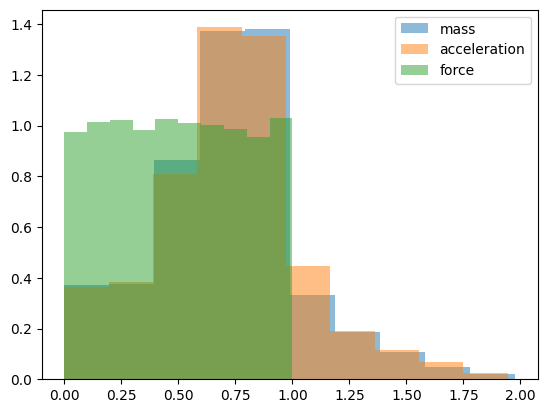

In [6]:
fig, ax = plt.subplots()

ax.hist(X[:, 0], alpha=0.5, density=True, label="mass")
ax.hist(X[:, 1], alpha=0.5, density=True, label="acceleration")
ax.hist(Y[:, 0], alpha=0.5, density=True, label="force")
ax.legend()

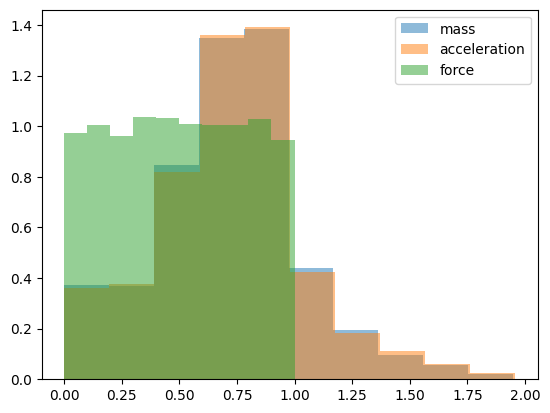

In [7]:
fig, ax = plt.subplots()

ax.hist(X[:, 2], alpha=0.5, density=True, label="mass")
ax.hist(X[:, 3], alpha=0.5, density=True, label="acceleration")
ax.hist(Y[:, 1], alpha=0.5, density=True, label="force")
ax.legend()

Ok, both now look identically distributed.

In [8]:
s_inds = np.random.permutation(range(X.shape[0]))  # shuffled indices

X_train = X[s_inds[:8000]]
Y_train = Y[s_inds[:8000]]
X_valid = X[s_inds[8000:]]
Y_valid = Y[s_inds[8000:]]

X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

(torch.Size([8000, 4]),
 torch.Size([8000, 2]),
 torch.Size([2000, 4]),
 torch.Size([2000, 2]))

## Training

I'll just do full gradient descent to keep things simple.

In [9]:
N = 1000  # number of epochs
hidden_dim = 16  # number of hidden units

model = Net(input_dim=4, hidden_dim=hidden_dim, output_dim=2)
loss_func = nn.MSELoss()
optimiser = Adam(model.parameters(), lr=1e-2)
log = []

for i in tqdm(range(N)):
    log_sample = {}

    # Training update
    model.train()
    model.zero_grad()
    Y_hat = model(X_train)
    loss = loss_func(Y_hat, Y_train)
    log_sample["train_loss"] = float(loss.detach())
    loss.backward()
    optimiser.step()

    # Validation set
    model.eval()
    Y_hat = model(X_valid)
    loss = loss_func(Y_hat, Y_valid)
    log_sample["valid_loss"] = float(loss.detach())

    log.append(log_sample)

df = pd.DataFrame(log)

  0%|          | 0/1000 [00:00<?, ?it/s]

## Results

In [10]:
from physics_mi.eval import *


# need to avoid flattening here because we have multiple outputs
def get_preds(model, X_valid, Y_valid):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    y_preds = out.numpy()
    y_targs = Y_valid.numpy()

    return y_preds, y_targs

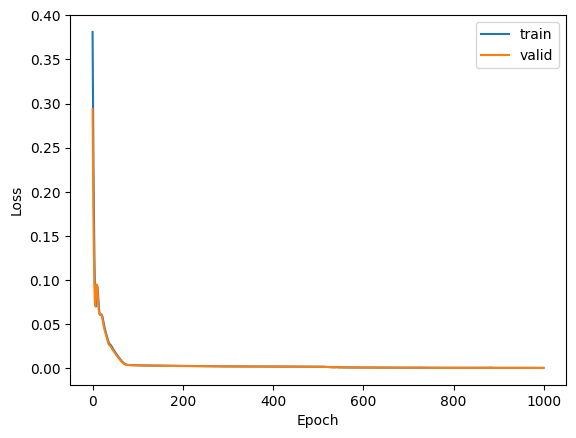

In [11]:
plot_loss(df["train_loss"], df["valid_loss"])

In [12]:
y_preds, y_targs = get_preds(model, X_valid, Y_valid)
y_preds.shape, y_targs.shape

((2000, 2), (2000, 2))

In [13]:
get_valid_loss(model, loss_func, X_valid, Y_valid)

tensor(0.0005)

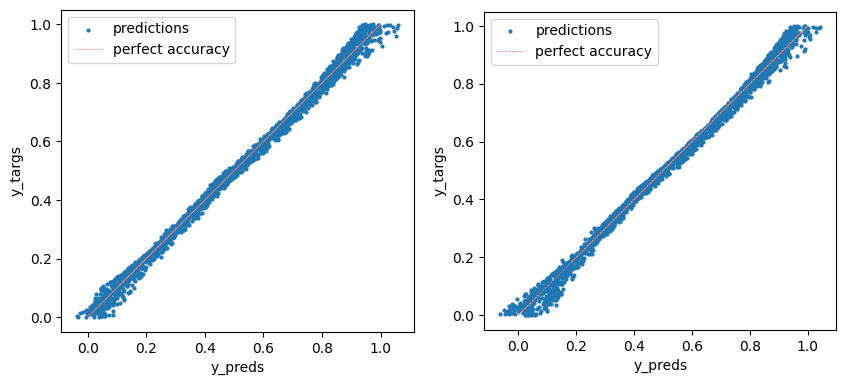

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

plot_results(y_preds[:, 0], y_targs[:, 0], ax=axes[0])
plot_results(y_preds[:, 1], y_targs[:, 1], ax=axes[1])

Both tasks seem to be doing well in parallel 👍

## Introspection

In [15]:
from physics_mi.analysis import capture_intermediate_outputs

In [16]:
def get_task_inputs(N=100, vary_task="A"):
    """
    Generates a dataset with N^2 examples for one of the two tasks (A or B). In each task subset, the other task's
    inputs are held constant and the alternative's task's inputs are varied across all the
    possible values in the interval [0,1] with precision 1/N.

    The purpose is to allow us to study how different tasks are represented in the dataset.

    Args:
        N (int, optional): Number of steps to sample unit input square. Defaults to 100.
        vary_task (str, optional): Which task to vary (the other's inputs will remained fixed at [0.5,0.5]). Defaults to "A".

    Returns:
        data: (N^2,4) the task dataset
    """
    pairs = np.concatenate(
        np.stack(np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))).T
    )
    pairs = torch.tensor(pairs, dtype=torch.float32)
    if vary_task == "A":
        inputs = torch.cat((pairs, torch.full((len(pairs), 2), 0.5)), dim=1)
    if vary_task == "B":
        inputs = torch.cat((torch.full((len(pairs), 2), 0.5), pairs), dim=1)
    return inputs

In [17]:
task_inputs = torch.cat(
    (get_task_inputs(100, vary_task="A"), get_task_inputs(100, vary_task="B"))
)
task_inputs.shape

torch.Size([20000, 4])

In [18]:
valid_ios = capture_intermediate_outputs(model, X_valid)
valid_ios["input"] = X_valid
task_ios = capture_intermediate_outputs(model, task_inputs)
task_ios["input"] = task_inputs

In [19]:
class ScaffoldNet(Net):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.requires_grad_(False)

    def forward(self, lidx, linputs):
        sub_net = self.layers[lidx : lidx + 1]
        out = sub_net(linputs)
        return out


scaffold_model = ScaffoldNet()
scaffold_model.load_state_dict(model.state_dict())

<All keys matched successfully>

In [20]:
ios = valid_ios
layer_keys = [
    "input",
    "layers.0.act",
    "layers.1.act",
    "layers.2.linear.bias",
]  # these are where from we would like to extract the components

In [21]:
from physics_mi.graph import generate_graph, add_plot_coords, nx_graph_from_pandas

In [22]:
ndf, edf = generate_graph(ios, layer_keys, scaffold_model)
ndf = add_plot_coords(ndf, layer_keys)
G = nx_graph_from_pandas(ndf, edf)

In [23]:
from physics_mi.analysis import plot_similarity_matrix, get_sims

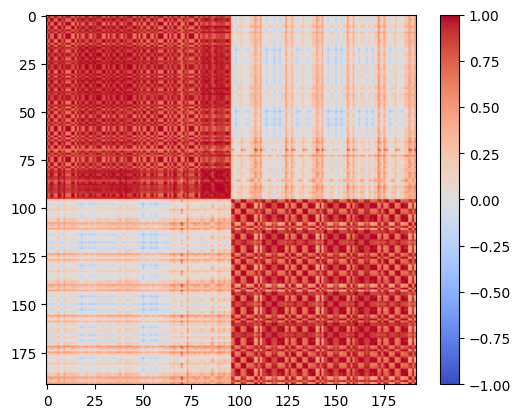

In [24]:
sims = get_sims(ndf, layer_keys[0])
plot_similarity_matrix(sims)

## Unit square input backprop

In [25]:
N = 10
pairs = np.concatenate(
    np.stack(np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))).T
)
pairs = torch.tensor(pairs, dtype=torch.float32)
inputs = torch.cat((pairs, torch.full((len(pairs), 2), 0.5)), dim=1)
inputs.shape

torch.Size([100, 4])

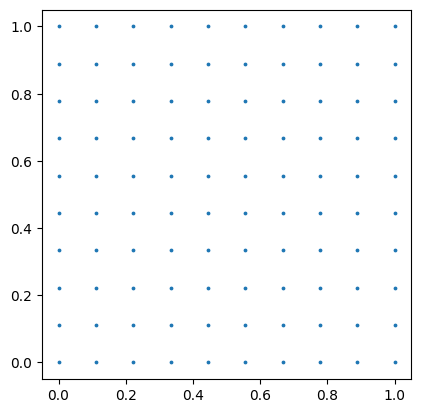

In [26]:
fig, ax = plt.subplots()

ax.scatter(*inputs[:, :2].T, s=3)
ax.set_aspect("equal")

In [27]:
ios = capture_intermediate_outputs(model, inputs)
ios["input"] = inputs

I'm going to need to modify my `generate_graph` function to just get the gradients and not to do any of the other fancy shit.

In [28]:
from physics_mi.graph import *


def get_gradients(component_acts, input_layer_acts):
    """
    Compute the unique gradients of the component activations with respect to the input layer activations.

    Args:
        component_acts (torch.Tensor): Tensor of component activations.
        input_layer_acts (torch.Tensor): Tensor of input layer activations.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: A tuple containing the unique input gradients and their corresponding norms.
    """
    loss = component_acts.mean()
    loss.backward(retain_graph=True)
    input_grads = input_layer_acts.grad.clone().detach()
    return input_grads, input_grads.norm(dim=1)


def generate_graph(ios, layer_keys, scaffold_model):
    nodes = create_output_layer_nodes(ios, layer_keys[-1])
    edges = []

    node_df = pd.DataFrame(nodes)
    node_idx = node_df["node"].max() + 1

    reversed_layer_keys = layer_keys[::-1]
    reverse_indices = list(range(len(layer_keys) - 1))[::-1]

    # Iterate over pairs of layers (backwards)
    for lidx, lk_input, lk_output in zip(
        reverse_indices,
        reversed_layer_keys[1:],
        reversed_layer_keys[:-1],
    ):
        input_layer_acts, output_layer_acts = forward_pass(
            ios, lk_input, lidx, scaffold_model
        )
        output_layer_nodes = node_df.loc[node_df["layer"] == lk_output]
        output_layer_comp_acts = process_outputs(output_layer_acts, output_layer_nodes)

        # backprop from each node/component of the output layer
        for cidx, comp_acts in enumerate(output_layer_comp_acts.transpose(1, 0)):
            # MODIFIED - this bit so that we can get the gradients of the input layer directly
            if lk_input == "input":
                return get_gradients(comp_acts, input_layer_acts)

            uq_input_grads, uq_input_grad_norms = get_unique_gradients(
                comp_acts, input_layer_acts
            )

            # store the gradients and their norms as nodes and edges
            for grad, norm in zip(uq_input_grads, uq_input_grad_norms):
                norm = float(norm)
                node = {"node": node_idx, "layer": lk_input, "comp": grad, "norm": norm}
                edge = {
                    "source": node_idx,
                    "target": output_layer_nodes["node"].iloc[cidx],
                    "weight": norm,
                }
                nodes.append(node)
                edges.append(edge)
                node_df = pd.DataFrame(nodes)
                node_idx += 1

            input_layer_acts.grad.zero_()

    edge_df = pd.DataFrame(edges)
    node_df.set_index("node", inplace=True)

    return node_df, edge_df

In [29]:
input_grads, input_grad_norms = generate_graph(ios, layer_keys, scaffold_model)

In [30]:
inputs.shape

torch.Size([100, 4])

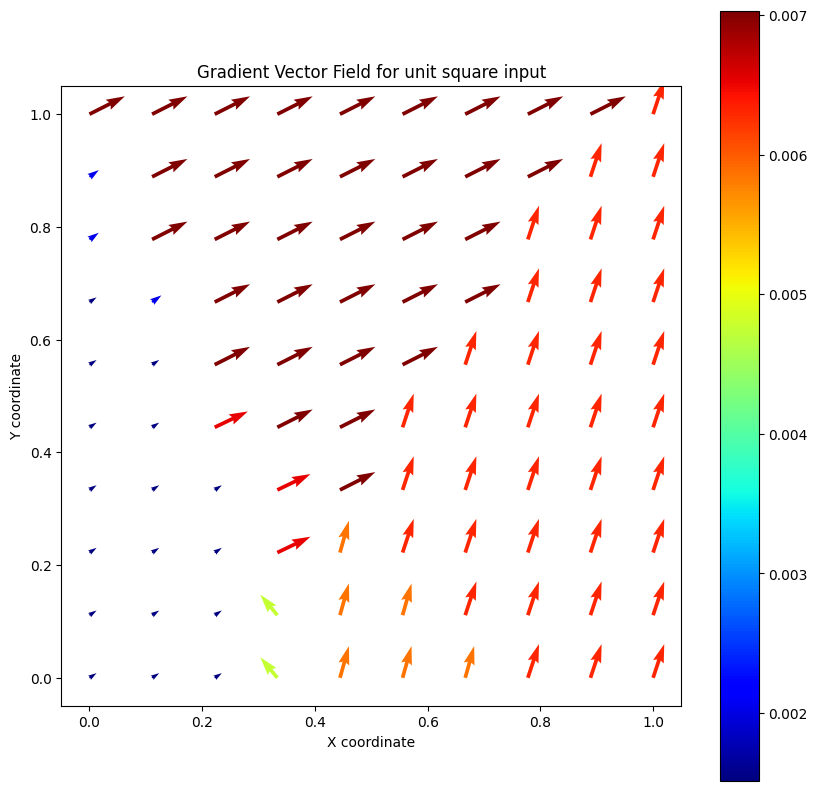

In [31]:
# Example tensors
coordinates = inputs[:, :2]
gradients = input_grads[:, :2]

# Convert to numpy arrays
coordinates_np = coordinates.numpy()
gradients_np = gradients.numpy()

# Calculate the norm (magnitude) of the gradient vectors if you want to scale arrows
# This is optional and depends on whether you want the arrow size to reflect the gradient magnitude
magnitudes = np.linalg.norm(gradients_np, axis=1)

# Plotting the vector field
fig, ax = plt.subplots(figsize=(10, 10))
quiver = ax.quiver(
    coordinates_np[:, 0],
    coordinates_np[:, 1],
    gradients_np[:, 0],
    gradients_np[:, 1],
    magnitudes,  # This controls the color based on magnitude
    scale=1e-1,  # Adjust this scale to control the arrow sizes
    scale_units="xy",
    angles="xy",
    cmap=plt.cm.jet,
)
plt.colorbar(quiver, ax=ax)  # To show the scale of colors representing the magnitudes
ax.set_xlabel("X coordinate")
ax.set_ylabel("Y coordinate")
ax.set_aspect("equal")
_ = ax.set_title("Gradient Vector Field for unit square input")

### Observations

- I love these. 
- I do feel like this might be very close to if not exactly demonstrating polytopes. We have regions of the input space in which the gradient is exactly the same therefore regions of the input space in which the input's effect on the output is essentially linear.
- It's nice to see that the vectors roughly make sense. If we plot the theoretical derivative of the input with respect to the output for a perfect multiplication operation (which I might just do...), we'd expect to see:
    - gradients roughly pointing towards higher $x_1$ and $x_2$ i.e. to make the output larger, either or both of our inputs must increase (with equal weighting to each input)
    - magnitudes are higher as we near $(1,1)$ - this is because the function is parabolic i.e. a given change in input will produce a larger output for higher input values 
- I can start to see (at least in this case) how the features as directions view maybe doesn't work so well? Many of these points share a very similar gradient direction but not magnitude.
- See the ideal theoretical gradients below 👇

### Theoretically perfect gradients

What would these look like? i.e. what is the network trying to mimic?

We can easily derive the gradients for a model that _perfectly_ represents the operation at hand (I'm pretty sure?).

$$
y = x_1 x_2
$$

$$
\nabla y = \begin{bmatrix} \frac{\partial y}{\partial x_1} \\ \frac{\partial y}{\partial x_2} \end{bmatrix} = \begin{bmatrix} x_2 \\ x_1 \end{bmatrix}
$$

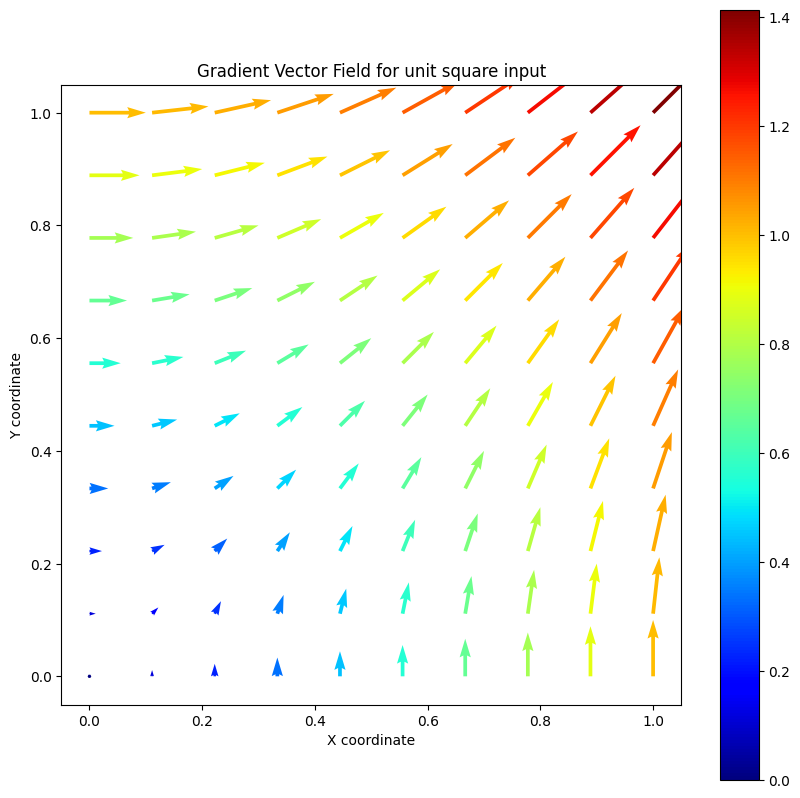

In [32]:
# Example tensors
coordinates = inputs[:, :2]  # [x_1, x_2]
gradients = inputs[:, :2][:, [1, 0]]  # [x_2, x_1]

# Convert to numpy arrays
coordinates_np = coordinates.numpy()
gradients_np = gradients.numpy()

# Calculate the norm (magnitude) of the gradient vectors if you want to scale arrows
# This is optional and depends on whether you want the arrow size to reflect the gradient magnitude
magnitudes = np.linalg.norm(gradients_np, axis=1)

# Plotting the vector field
fig, ax = plt.subplots(figsize=(10, 10))
quiver = ax.quiver(
    coordinates_np[:, 0],
    coordinates_np[:, 1],
    gradients_np[:, 0],
    gradients_np[:, 1],
    magnitudes,  # This controls the color based on magnitude
    scale=10,  # Adjust this scale to control the arrow sizes
    scale_units="xy",
    angles="xy",
    cmap=plt.cm.jet,
)
plt.colorbar(quiver, ax=ax)  # To show the scale of colors representing the magnitudes
ax.set_xlabel("X coordinate")
ax.set_ylabel("Y coordinate")
ax.set_aspect("equal")
_ = ax.set_title("Gradient Vector Field for unit square input")